the dataset is present in /kaggle/working

In [88]:
cd /kaggle/input/stylegan-xl128-850/rosetta_neurons

/kaggle/input/stylegan-xl128-850/rosetta_neurons


In [3]:
#@title Requirements
!pip install -r requirements.txt
!pip install transformers
!pip install openai-clip
!pip install einops
!pip install pytorch_pretrained_biggan
!pip install Ninja
!pip install timm==0.4.12
!pip install dill

  Cloning https://github.com/openai/CLIP.git (to revision b46f5ac7587d2e1862f8b7b1573179d80dcdd620) to /tmp/pip-install-pcc4g0hm/clip_583a1109417940c1aa155a79f56229f9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-pcc4g0hm/clip_583a1109417940c1aa155a79f56229f9
  Running command git rev-parse -q --verify 'sha^b46f5ac7587d2e1862f8b7b1573179d80dcdd620'
  Running command git fetch -q https://github.com/openai/CLIP.git b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Running command git checkout -q b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Resolved https://github.com/openai/CLIP.git to commit b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/arogozhnikov/einops.git (to revision d6f7910dc80c8413b7bb400f6f6ad24e3c5f5b0f) to /tmp/pip-install-pcc4g0hm/einops_800e10bfe2f24646b13273e65bc4149f
  Running command git clone --filter=blob:none --quiet https://github.com/arogozhnikov/eino

IMPORTS

In [89]:
import os
import sys
current = os.path.dirname(os.path.realpath("rosetta-inversion-stylegan-xl.ipynb"))
parent = os.path.dirname(current)
sys.path.append(parent)
import torch
import torch.nn.functional as F
import torch.hub
import copy
from time import perf_counter
import dill
import click
import imageio
import numpy as np
import PIL.Image
import os.path
from tqdm import trange
import dnnlib
import legacy
from styleganxl import metric_utils
from styleganxl.diffaug import DiffAugment
from pg_modules.blocks import Interpolate
import torchvision
from torchvision.models import resnet50
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import requests
import time
import pickle
import math
import timm
import tensorflow
from transformers import CLIPProcessor, CLIPModel
import clip
from mae import load_mae
import timm.models.vision_transformer
from typing import Text
import os.path
from match_utils import matching, stats, proggan, nethook, dataset, loading, plotting, layers, universal,models

In [90]:
num_steps=500
lr_rampdown_length = 0.25
lr_rampup_length = 0.05
device = 'cuda:0'
initial_learning_rate = 0.001
seed = 35
classs = 850#class-change accordingly

In [91]:
device = torch.device(device)
np.random.seed(seed)
torch.manual_seed(seed)

discr_mode = 'clip'

In [92]:
# Load models and tables
discr, discr_layers = models.load_discr(discr_mode, device)


G, gan_layers = models.load_gan("styleganxl", device)
ganlayers, discrlayers = layers.get_layers(G,gan_layers, discr, discr_layers,"styleganxl", discr_mode, device)


In [93]:
perfect_matches = []
discr_perfect_matches = []


universal_matches, stats= universal.get_universal_activations(
    'matches/styleganxl/resnet50/850',
    'matches/styleganxl/mae/850', 
    'matches/styleganxl/dino/850', 
    'matches/styleganxl/dino_vitb16/850', 
    'matches/styleganxl/clip/850',device, n = 3)#change to appropriate paths
for i, j in universal_matches.items():
    perfect_matches.append(i)
    discr_perfect_matches.append(j[-1])

for i, unit in enumerate(perfect_matches):
    perfect_matches[i] = layers.find_act(perfect_matches[i], ganlayers)
for i, unit in enumerate(discr_perfect_matches):
    discr_perfect_matches[i] = layers.find_act(discr_perfect_matches[i], discrlayers)


Loading...
Done
Loading...
Done
Loading...
Done
Loading...
Done
Loading...
Done


In [94]:
discr = nethook.InstrumentedModel(discr)
discr.retain_layers(discr_layers)

G = nethook.InstrumentedModel(G)
G.retain_layers(gan_layers, detach = False)

In [95]:
!pip install gdown

In [96]:
!gdown 1KDwcozWVixXSTc-BhExnvTQ6OPvY5cxP -O /kaggle/working/teddy.png

Downloading...
From: https://drive.google.com/uc?id=1KDwcozWVixXSTc-BhExnvTQ6OPvY5cxP
To: /kaggle/working/teddy.png
100%|█████████████████████████████████████████| 240k/240k [00:00<00:00, 124MB/s]


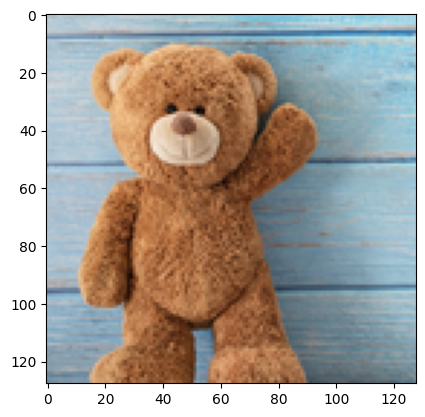

In [97]:
# Load target image.
target_fname = '/kaggle/working/teddy.png'
model_resolution = 128
target_pil = PIL.Image.open(target_fname).convert('RGB')
w, h = target_pil.size
s = min(w, h)
target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
target_pil = target_pil.resize((model_resolution,model_resolution), PIL.Image.LANCZOS)
target_uint8 = np.array(target_pil, dtype=np.uint8)
plt.imshow(target_uint8)

In [98]:
discr_im = Image.open(target_fname).convert('RGB')
discr_im = torchvision.transforms.ToTensor()(discr_im).unsqueeze(0).to(device)   

discr_im = torch.nn.functional.interpolate(discr_im, size = (224,224), mode = "bicubic")
discr_im = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), 
                                           (0.26862954, 0.26130258, 0.27577711))(discr_im)
_ = discr.model.encode_image(discr_im)
discr_activs =  matching.store_activs(discr, discr_layers)

##discr activs
discr_stats = stats[-1][1]

#normalize
eps = 0.00001
for i,_ in enumerate(discr_activs):
    discr_activs[i] = (discr_activs[i]-discr_stats[i][0])/(discr_stats[i][1]+eps)

discr_perfect_activs = []
for idx in discr_perfect_matches:
    discr_perfect_activs.append(discr_activs[idx[0]][:,idx[1],:,:].unsqueeze(0))

In [99]:
target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)
target_images = target.unsqueeze(0).to(device).to(torch.float32)

In [142]:
z = dataset.truncate_noise((1,64),1).to(device)
c = torch.zeros((1,1000)).to(device)
c[0,850]=1

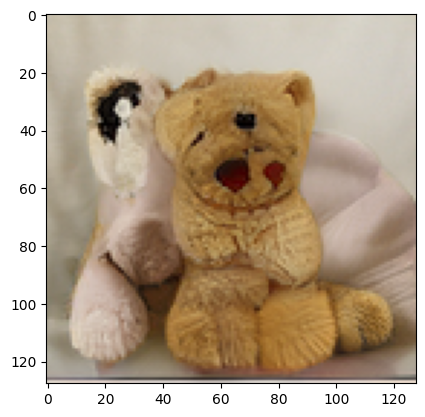

In [143]:
im = G(z,c,0.7)
im = torch.permute(im[0], (1,2,0))
im = (im+1)/2
plt.imshow(im.detach().cpu())

In [144]:
z1 = torch.tensor(z.clone(), dtype=torch.float32, device=device, requires_grad=True).to(device) # pylint: disable=not-callable
optimizer = torch.optim.Adam([z1], betas=(0.9, 0.999), lr=initial_learning_rate)

/tmp/ipykernel_26/1204496168.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z1 = torch.tensor(z.clone(), dtype=torch.float32, device=device, requires_grad=True).to(device) # pylint: disable=not-callable


Plotting all concepts

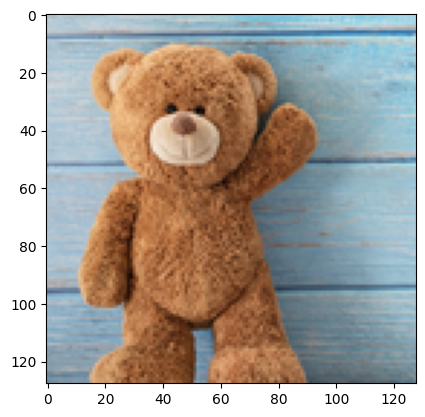

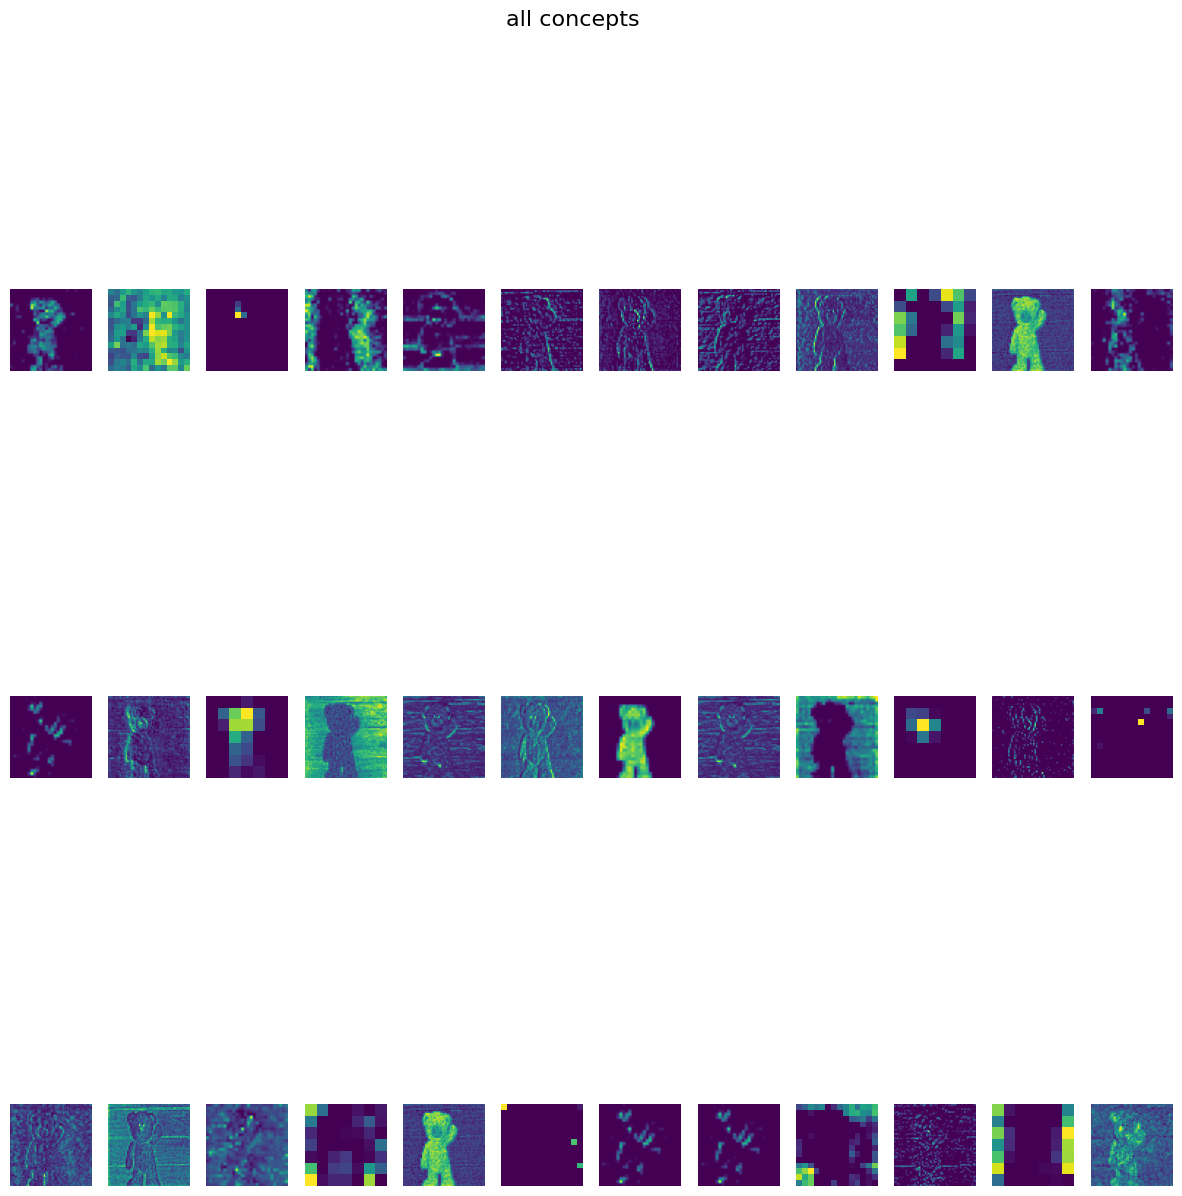

In [117]:
plt.imshow(target_uint8)
num_rows = 3
num_cols = len(discr_perfect_activs)//3

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# Set a global label for the entire plot
fig.suptitle('all concepts', fontsize=16)

# Plot each image in the subplot
for i in range(num_rows):
    for j in range(num_cols):
        
        index = i * num_cols + j
        if index < len(discr_perfect_activs):
#             print(index)
            axs[i, j].imshow(discr_perfect_activs[index].squeeze().cpu())  # Assuming images are grayscale
            axs[i, j].axis('off')  # Turn off axis labels
        else:
            break
#         axs[i, j].set_title(labels[index], fontsize=8)

In [128]:
invert_idx = 34

In [129]:
gan_stats = stats[-1][0]

In [135]:
step

11

In [ ]:
all_images = []
for step in range(200):
    # Learning rate schedule.
    t = step / num_steps
    lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
    lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
    lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
    lr = initial_learning_rate * lr_ramp
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Synth images from opt_w.
    synth_images = G(z1,c,0.7)


    # track images
    synth_images = (synth_images + 1) * (255/2)
    synth_images_np = synth_images.clone().detach().permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    all_images.append(synth_images_np)

    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    if synth_images.shape[2] > 256:
        synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')


    gan_activs = matching.store_activs(G, gan_layers)
    #normalize all activations
    eps = 0.00001
    for i,_ in enumerate(gan_activs):
        gan_activs[i] = (gan_activs[i]-gan_stats[i][0])/(gan_stats[i][1]+eps)

    gan_perfect_activs = []
    for idx in perfect_matches:
        gan_perfect_activs.append(gan_activs[idx[0]][:,idx[1],:,:])



    #pearson correlation
    a_loss = 0
    counter = len(gan_perfect_activs)
    i = invert_idx
#     for i, _ in enumerate(gan_perfect_activs):
    map_size = max((gan_perfect_activs[i].shape[1], discr_perfect_activs[i].shape[1]))
    gan_activ_new = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(gan_perfect_activs[i].unsqueeze(0))
    discr_activ_new = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(discr_perfect_activs[i])
    prod = torch.einsum('aixy,ajxy->ij', gan_activ_new,discr_activ_new)
    div1 = torch.sum(gan_activ_new**2)
    div2 = torch.sum(discr_activ_new**2)
    corr = prod/torch.sqrt(div1*div2)
    a_loss += corr


    a_loss *= -1
    a_loss = a_loss / counter
    l_reg = torch.mean((z1-z)**2)
    # Features for synth images.
    loss = a_loss + 0 * l_reg
    # Step
    optimizer.zero_grad(set_to_none=True)

    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        msg  = f'[ step {step+1:>4d}/{num_steps}] '
        msg += f'[ a_loss: {float(a_loss):5.2f} loss_reg: {0.1 * float(l_reg):5.2f}] '
        print(msg)
        plt.imshow(synth_images_np)
        plt.show()
